<a href="https://colab.research.google.com/github/parthatom/CellClassificication/blob/master/Classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip /content/drive/"My Drive"/Data/final

Archive:  /content/drive/My Drive/Data/final.zip
   creating: train_final/
   creating: train_final/1/
 extracting: train_final/1/f1756.png  
 extracting: train_final/1/f1071.png  
 extracting: train_final/1/f1874.png  
 extracting: train_final/1/f3748.png  
 extracting: train_final/1/f3212.png  
 extracting: train_final/1/f8659.png  
 extracting: train_final/1/f6217.png  
 extracting: train_final/1/f2863.png  
 extracting: train_final/1/f3017.png  
 extracting: train_final/1/f3325.png  
 extracting: train_final/1/f4215.png  
 extracting: train_final/1/f1982.png  
 extracting: train_final/1/f9672.png  
 extracting: train_final/1/f1023.png  
 extracting: train_final/1/f5735.png  
 extracting: train_final/1/f6649.png  
 extracting: train_final/1/f826.png  
  inflating: train_final/1/f4990.png  
 extracting: train_final/1/f7608.png  
 extracting: train_final/1/f2160.png  
 extracting: train_final/1/f4931.png  
 extracting: train_final/1/f7056.png  
 extracting: train_final/1/f4308.png  
 

In [0]:
!mkdir test_images
!mkdir train_images


In [0]:
!unzip /content/drive/"My Drive"/dc99623a-c-vista_data
!unzip /content/test_final -d /content/test_images
!unzip /content/train_final -d /content/train_images


Archive:  /content/drive/My Drive/dc99623a-c-vista_data.zip
  inflating: sample.csv              
 extracting: test_final.zip          
  inflating: train.csv               
 extracting: train_final.zip         


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import sys
import math
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import PIL
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
input_path = Path("/content/")
%matplotlib inline
import argparse
import shutil
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import sklearn
from sklearn.metrics import multilabel_confusion_matrix 
plt.ion()   # interactive mode

In [0]:
root = input_path
df_train = pd.read_csv( input_path / 'train.csv')
train_image_path = input_path / "train_images"
test_image_path = input_path / "test_images"
label= df_train.id.values  

In [0]:
folders = os.listdir(root)
from pathlib import Path

In [0]:
train_dir = train_image_path 
train_final_path = input_path / "train_final"
val_final_path = input_path / "val_final"

In [7]:
i=0
for classes in os.listdir(val_final_path):
  for _, dirs, files in os.walk(val_final_path/ Path(classes)):
    print(len(files))
    i += len(files)
print("Total =", i)

83
93
95
80
85
69
52
75
80
78
73
78
91
55
Total = 1087


In [0]:
class imageload(Dataset):
  def __init__(self,root, mode = 'train'):
    self.Images= []
    self.mode = mode
    self.path_list = []
    self.label_list = []
    self.transform = transforms.CenterCrop(100)
    folders = os.listdir(root)
    folder= mode+"_final"
    folder_path = os.path.join(root,folder)
    for img_class in os.listdir(folder_path):
      class_path = os.path.join(folder_path, img_class)
      for ims in os.listdir(class_path):
        #print(ims, class_path)
        img_path = os.path.join(class_path,ims)
        #print(img_path)
        #I = plt.imread(img_path)
        self.path_list.append(img_path)
        self.label_list.append(str(img_class))
    #data = [(x,y) for x,y in zip (self.Images,label)] 
    #self.data = data
  def __len__ (self):
    return len(self.path_list)
  def __getitem__(self,index):
    img = plt.imread(self.path_list[index])
    img_tensor = torch.tensor(np.asarray(img, dtype = np.float32))
    transform1 = transforms.Resize((256,256), interpolation=PIL.Image.BOX)
    transform = transforms.ToPILImage()
    transform2 = transforms.ToTensor()
    transform3 = transforms.CenterCrop(224)
    transform4 = transforms.RandomAffine(50)
    transform5 = transforms.RandomVerticalFlip()
    img_tensor = transform3(transform1(transform(img_tensor)))
    if self.mode!='train':
      img_tensor = transform5(transform4(img_tensor))
    label = torch.tensor((int(self.label_list[index])-1), dtype = torch.long)
    return (transform2(img_tensor), label)
    

In [0]:
train_dataset = imageload(os.path.join(root, ""), mode ='train')
val_dataset = imageload(os.path.join(root,""), mode = 'val')

In [0]:
def init_weights(m):
    if (type(m) == nn.Linear or type(m) == nn.Conv2d ):
      torch.nn.init.xavier_uniform_(m.weight)
      #m.data.bias.fill_(0.01)

In [0]:
class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                                nn.ReLU(inplace = True), 
                                nn.MaxPool2d(2, stride = 2),
                                nn.BatchNorm2d(32))
    self.layer1.apply(init_weights)
    self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), 
                                nn.ReLU(inplace = True), 
                                nn.MaxPool2d(2, stride = 2),
                                nn.BatchNorm2d(64))
    self.layer2.apply(init_weights)
    self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding =1), 
                                nn.ReLU(inplace = True), 
                                nn.Conv2d(128, 128, 3, padding =1), 
                                nn.ReLU(inplace = True), 
                                nn.MaxPool2d(2, stride = 2),
                                nn.BatchNorm2d(128))
    self.layer3.apply(init_weights)
    self.layer4 = nn.Sequential(nn.Conv2d(128, 256, 3, padding = 1), 
                                nn.ReLU(inplace = True), 
                                nn.Conv2d(256, 256, 3, padding = 1), 
                                nn.ReLU(inplace = True), 
                                nn.MaxPool2d(2, stride = 2),
                                nn.BatchNorm2d(256))
    self.layer4.apply(init_weights)
    #self.layer5 = nn.Sequential(nn.Conv2d(256, 256, 3, padding = 1), nn.ReLU(inplace = True), nn.Conv2d(256, 256, 3, padding = 1), nn.ReLU(inplace = True), nn.MaxPool2d(2, stride = 2))
    self.avgpool = nn.AdaptiveAvgPool2d((7,7))
    self.layer6 = nn.Sequential(nn.Linear(256*7*7, 1024),
                                nn.ReLU(inplace = True),
                                nn.Dropout(p=0),
                                nn.Linear(1024, 128),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p = 0),
                                nn.Linear(128, 14))
    self.layer6.apply(init_weights)
  def forward(self,x):
    out = self.layer1(x)
    #print(out.shape)
    out = self.layer2(out)
    #print(out.shape)
    out = self.layer3(out)
    #print(out.shape)
    out = self.layer4(out)
    #print(out.shape)
    #out = self.layer5(out)
    #print(out.shape)
    out = self.avgpool(out)
    #print(out.shape)
    out = torch.flatten(out, 1)
    #print(out.shape)
    out = nn.Softmax(dim = 1)(self.layer6(out))
    #print(out.shape)
    return out

In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F 

class Model(torch.nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.layer2 = nn.Sequential(nn.Conv2d(20, 24, 5), nn.ConstantPad2d(4, 0),nn.Conv2d(24, 15, 1), nn.Conv2d(15, 18, 3),nn.ConstantPad2d(4, 0), nn.Conv2d(18, 20, 3),nn.ConstantPad2d(2, 0), nn.MaxPool2d(2, stride = 2))
    self.layer3 = nn.Sequential(nn.Conv2d(20, 24, 3),nn.ConstantPad2d(4, 0), nn.Conv2d(24, 30, 3), nn.ReflectionPad2d(2),nn.Conv2d(30, 20, 1), nn.Conv2d(20, 30, 3, stride = 2), nn.MaxPool2d(2))
    self.layer4 = nn.Sequential(nn.Conv2d(30,35, 3),
                                nn.ReflectionPad2d(2),
                                nn.Conv2d(35, 24, 1),
                                nn.Conv2d(24, 26, 3),
                                nn.Conv2d(26, 30, 3),
                                nn.MaxPool2d(2, stride =2))
    self.conv1 = nn.Sequential(nn.Conv2d(1, 10, kernel_size=3), nn.ReflectionPad2d(2))
    self.conv2 = nn.Conv2d(10, 15, kernel_size=3)
    self.conv3 = nn.Conv2d(15, 20, kernel_size=3)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(30,20)
    self.fc2 = nn.Linear(20,14)
  def forward(self,x):
              x = F.relu(F.max_pool2d(self.conv1(x), 2))
              x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
              x = F.relu(F.max_pool2d(self.conv3(x), 2))
              x = F.relu(self.layer2(x))
              x = F.leaky_relu(self.layer3(x))
              x = F.relu(self.layer4(x))
              x=x.view(-1,30)
              x=F.relu(self.fc1(x))
              x = F.dropout(x)
              x=self.fc2(x)
              x = nn.LogSoftmax( dim =1)(x)
              return x

In [0]:
net = Model()

In [0]:
loader = DataLoader(train_dataset, batch_size = 384, shuffle = True)
val_loader =  DataLoader(val_dataset, batch_size = 128, shuffle = False)

In [0]:
c = torch.zeros(14, dtype = torch.int32)
for _, labels in loader:
  c[int(labels)] += 1
print(c) 

tensor([722, 705, 720, 731, 715, 720, 717, 725, 707, 445, 448, 709, 722, 727],
       dtype=torch.int32)


In [0]:
_, label = next(iter(loader))
labels = torch.zeros((256,14))
labels.scatter_(1, label.view(256,1), 1)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

torch.Size([128, 1, 224, 224]) tensor([ 7,  9, 13,  8, 12,  2,  8,  8,  6, 12,  2,  9,  3,  6,  7,  6,  0,  4,
        10,  2, 13,  8,  2,  3, 11,  5, 12,  2,  1,  5,  0,  4,  3,  4,  6, 13,
         1,  6,  1,  7,  1,  9,  0, 12,  4,  1,  7,  5, 13, 12,  1,  1,  0,  5,
        11,  6,  7,  5,  9, 13,  0,  0,  3,  5,  6, 13,  1, 13, 10,  8, 11,  8,
         4,  8,  6,  7,  0,  1, 11,  7,  1,  1,  7,  0, 11,  3,  5, 12,  7,  0,
        10,  4, 11,  9,  7, 13,  3, 13,  6,  4,  6,  2, 13,  2, 11, 12, 13,  1,
         2,  4, 13,  4, 11,  4,  1,  4,  9, 11,  0, 10,  7,  8,  3, 12,  4, 13,
         6,  6])


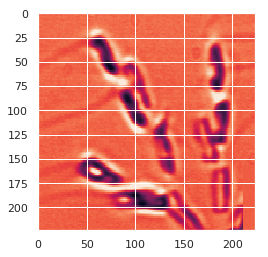

In [0]:
%matplotlib inline
image, label = next(iter(loader))
trans = transforms.ToPILImage()
print(image.shape, label)
img = trans(image[0])
plt.imshow(img)

In [0]:
import torch.optim as optim



In [0]:
model.load_state_dict(torch.load(Path("/content/accuforty.pth")))
model = model.to(device)

In [0]:
ps = torch.randint(low = 0, high = 13, size = (128, 1))
labels = torch.randint(low = 0, high = 13, size = (128, 1))
confusion = multilabel_confusion_matrix(ps.numpy(), labels.numpy())

In [27]:
print(confusion)

[[[110   7]
  [ 10   1]]

 [[103  17]
  [  8   0]]

 [[107  12]
  [  9   0]]

 [[114   2]
  [ 11   1]]

 [[108   5]
  [ 12   3]]

 [[109  10]
  [  8   1]]

 [[104  13]
  [ 11   0]]

 [[108   9]
  [ 11   0]]

 [[108   8]
  [ 10   2]]

 [[112   8]
  [  8   0]]

 [[112  10]
  [  6   0]]

 [[111   9]
  [  5   3]]

 [[113   7]
  [  8   0]]]


In [0]:
def train(model, criterion, optimizer, device, epochs=20 ):
  loss_list = []
  val_losses = []
  confusion = torch.zeros((14,14)).to(device)
  accuracy = 0
  for e in range(epochs):
      running_loss = 0
      accuracy = 0
      model.train()
      for images, labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          ps = model(images)
          loss = criterion(ps, labels)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          _,ps = (ps).topk(1, dim = -1)
          accuracy+= torch.mean((labels == ps).type(torch.FloatTensor))
          running_loss += loss.item()
          
      else:
          with torch.no_grad():
            model.eval()
            val_accuracy = 0
            valing_loss = 0
            for images, labels in val_loader:
              images = images.to(device)
              labels =  labels.to(device)
              ps = model(images)
              valloss = criterion(ps, labels)
              _, ps = (ps).topk(1, dim = -1)
              val_accuracy += torch.mean((labels == ps).type(torch.FloatTensor))
              for i in range(len(ps)):
                confusion[ps[i], labels[i]] += 1
              valing_loss += valloss.item()
            val_losses.append(valing_loss)
            loss_list.append(running_loss)
            print(f"Epoch: {e+1}/{epochs}...")
            print(f"Training loss: {running_loss/len(loader):.3f}")
            print(f"Validation loss: {valing_loss/len(val_loader):.3f}")
            print(f"Accuracy: {accuracy/len(loader)*100:.3f}")
            print(f"Accuracy: {val_accuracy/len(val_loader)*100:.3f}")
  return loss_list, val_losses, confusion

In [24]:
alpha = [0.003, 0.001, 0.0003]
loss_lists = []
val_loss_lists = []
confusion_list = []
accuracies = []
criterion = nn.NLLLoss()
for lr in alpha:
  model = VGG()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  losses, valosses, confusion = train(model, criterion, optimizer, device, epochs = 5)
  loss_lists.append(losses)
  val_loss_lists.append(valosses)
  confusion_list.append(confusion)

RuntimeError: ignored

In [16]:
images, labels = next(iter(loader))
images = images.to(device)
labels = labels.to(device)
ps = model(images)
_, ps = (ps).topk(1, dim = -1)
print(ps.shape)
print(labels.shape)

RuntimeError: ignored

In [20]:
ps = torch.randint(low = 0, high = 14, size = (384,14))
_, ps = (ps).topk(1, dim = -1)
labels = torch.randint(low = 0, high = 14, size = (384,1))
print(ps.shape)
confusion =  torch.zeros((14,14))
for i in range(len(ps)):
  confusion[ps[i], labels[i]] += 1
print(confusion.shape)

torch.Size([384, 1])
torch.Size([14, 14])


In [26]:
print((confusion_list[2].shape))

(8, 2, 2)


tensor([[3., 4., 1., 2., 1., 3., 4., 4., 1., 6., 5., 3., 1., 3.],
        [1., 1., 2., 1., 2., 1., 0., 2., 0., 5., 4., 4., 1., 0.],
        [1., 2., 0., 0., 4., 1., 1., 1., 3., 2., 4., 0., 1., 1.],
        [2., 3., 0., 1., 3., 1., 1., 1., 2., 1., 4., 3., 4., 1.],
        [1., 4., 1., 2., 4., 3., 0., 3., 1., 2., 3., 0., 0., 3.],
        [2., 0., 1., 2., 4., 1., 5., 2., 2., 3., 3., 0., 1., 1.],
        [4., 3., 3., 3., 5., 0., 2., 6., 2., 1., 1., 2., 2., 4.],
        [3., 1., 1., 0., 1., 0., 3., 0., 2., 0., 2., 1., 2., 0.],
        [1., 1., 0., 0., 0., 1., 1., 4., 0., 3., 4., 2., 4., 0.],
        [1., 3., 1., 1., 0., 1., 1., 4., 2., 4., 2., 3., 1., 3.],
        [3., 2., 0., 3., 1., 1., 2., 2., 2., 1., 1., 3., 0., 3.],
        [4., 1., 1., 1., 2., 3., 1., 1., 5., 2., 0., 0., 4., 1.],
        [1., 2., 2., 0., 1., 1., 1., 2., 0., 3., 1., 1., 0., 4.],
        [3., 1., 7., 3., 3., 4., 3., 5., 2., 4., 2., 3., 1., 5.]])


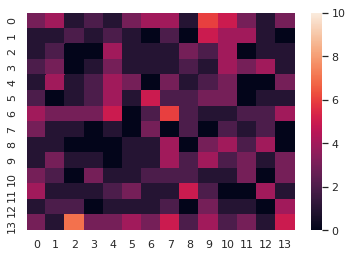

In [22]:
import seaborn as sns
sns.set()
a = confusion
print(a)
ax = sns.heatmap(a, vmin = 0, vmax = 10)

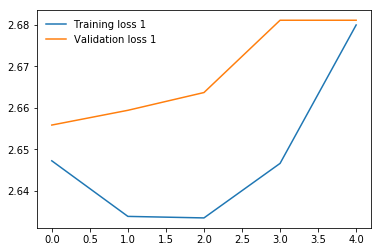

In [0]:
plt.plot(np.asarray(loss_lists[0])/len(loader), label='Training loss '+str(1))
plt.plot(np.asarray(val_loss_lists[0])/len(val_loader), label='Validation loss '+str(1))
plt.legend(frameon=False)

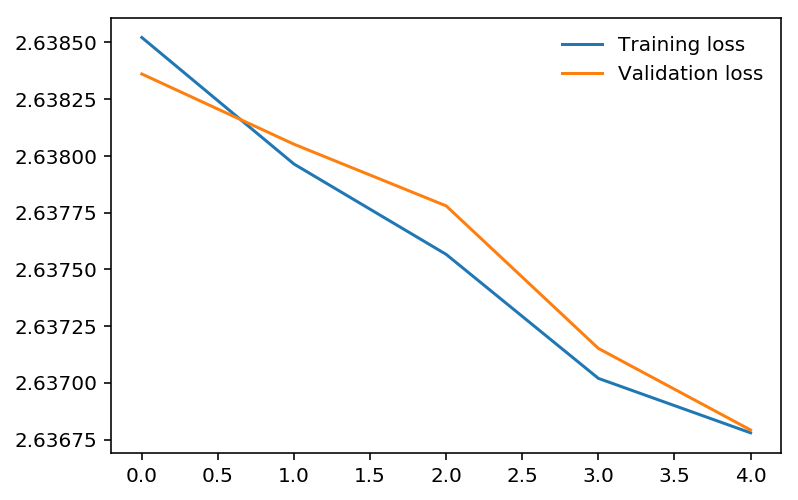

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(np.asarray(loss_list)/len(loader), label='Training loss')
plt.plot(np.asarray(val_losses)/len(val_loader), label='Validation loss')
plt.legend(frameon=False)

In [0]:
class testload(Dataset):
  def __init__(self,root):
    self.Images= []
    self.path_list = []
    self.label_list = []
    self.transform = transforms.CenterCrop()
    folders = os.listdir(root)
    folder= Path("test_images")
    folder_path = os.path.join(root,folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path,img)
        #print(img_path)
        #I = plt.imread(img_path)
        self.path_list.append(img_path)
        self.label_list.append(str(img))
    #data = [(x,y) for x,y in zip (self.Images,label)] 
    #self.data = data
  def __len__ (self):
    return len(self.path_list)
  def __getitem__(self,index):
    img = plt.imread(self.path_list[index])
    label = self.label_list[index]
    img_tensor = torch.tensor(np.asarray(img, dtype = np.float32))
    transform1 = transforms.Resize((128,128), interpolation=PIL.Image.BOX)
    transform = transforms.ToPILImage()
    transform2 = transforms.ToTensor()
    #label = self.label_list[index]
    return transform2(transform1(transform(img_tensor))), label
    

In [0]:
tload = testload(input_path/"test_images")

TypeError: ignored

In [0]:
testloader = DataLoader(testload, batch_size=1, shuffle = False)

In [0]:
sample = pd.read_csv(input_path/"sample.csv")

In [0]:
sample.head()

,id,label
0,f1.png,1
1,f2.png,1
2,f3.png,1
3,f4.png,1
4,f5.png,1


In [0]:
images, labels = next(iter(testloader))

TypeError: ignored